# ARC Dataset Creation for Qwen2.5

This notebook creates training, validation, and test datasets for two tasks:
1. **examples + input → output** (основная задача)
2. **inputs → input** (генерация новых сеток)

Each dataset includes metadata and is returned as a pandas DataFrame.

Uses CFG from fine-tuning.py for consistency.

In [ ]:
%%time
is_dry_run = False
if not is_dry_run:
    !bash /kaggle/input/arc24-source-code/install_libraries.sh

In [11]:
import sys
import os
import json
import pandas as pd
from tqdm.auto import tqdm
from transformers import AutoTokenizer
from dataclasses import asdict

# Add arc24 to path
sys.path.append('./arc24-source-code')

from arc24.data import load_arc_data_with_solutions
from arc24.prompting import create_prompts_from_task
from arc24.encoders import create_grid_encoder

# Import CFG from fine-tuning script
from dataclasses import dataclass, field
from typing import Optional, List

# Import CFG class
import importlib.util
spec = importlib.util.spec_from_file_location("fine_tuning", "./arc24-source-code/fine-tuning.py")
fine_tuning_module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(fine_tuning_module)
CFG = fine_tuning_module.CFG

In [18]:
# Create configuration instance
cfg = CFG(
    model_path='kaggle/input/qwen2.5/transformers/0.5b-instruct/1',
    grid_encoder='GridShapeEncoder(RowNumberEncoder(MinimalGridEncoder()))',
    max_seq_len=4096,
    verbose=True,
    output_dir='./output/datasets_qwen25',
    n_gpus=1
)

print("Configuration:")
print("="*60)
for key, value in asdict(cfg).items():
    if key in ['model_path', 'grid_encoder', 'max_seq_len', 'output_dir', 'verbose']:
        print(f"  {key}: {value}")
print("="*60)

Configuration:
  verbose: True
  model_path: kaggle/input/qwen2.5/transformers/0.5b-instruct/1
  output_dir: ./output/datasets_qwen25
  max_seq_len: 4096
  grid_encoder: GridShapeEncoder(RowNumberEncoder(MinimalGridEncoder()))


In [13]:
# Prompt versions for two tasks
TASK1_PROMPT = 'output-from-examples-v1'  # examples + input → output
TASK2_PROMPT = 'input-from-inputs-v0'     # inputs → input (generation)

# Data paths
TRAIN_CHALLENGES = './kaggle/input/arc-prize-2025/arc-agi_training_challenges.json'
TRAIN_SOLUTIONS = './kaggle/input/arc-prize-2025/arc-agi_training_solutions.json'
EVAL_CHALLENGES = './kaggle/input/arc-prize-2025/arc-agi_evaluation_challenges.json'
EVAL_SOLUTIONS = './kaggle/input/arc-prize-2025/arc-agi_evaluation_solutions.json'
TEST_CHALLENGES = './kaggle/input/arc-prize-2025/arc-agi_test_challenges.json'

print(f"\nTask 1 prompt version: {TASK1_PROMPT}")
print(f"Task 2 prompt version: {TASK2_PROMPT}")


Task 1 prompt version: output-from-examples-v1
Task 2 prompt version: input-from-inputs-v0


In [16]:
from accelerate.logging import get_logger
from accelerate import Accelerator
logger = get_logger(__name__)

if cfg.report_to == 'wandb':
    accelerator = Accelerator(log_with=cfg.report_to)
    accelerator.init_trackers(
        project_name=os.path.basename(os.path.dirname(cfg.output_dir)),
        config=cfg,
        init_kwargs={"wandb": dict(dir=cfg.output_dir,
                                    name=os.path.basename(cfg.output_dir))}
    )
else:
    accelerator = Accelerator()
logger.info(f'Train configuration: {asdict(cfg)}')

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


2025-09-30 08:45:18,535 - __main__ - INFO - <module> - Train configuration: {'verbose': True, 'resume_from_checkpoint': True, 'model_path': '/kaggle/input/qwen2.5/transformers/0.5b-instruct/1', 'adapter_path': None, 'use_4bit_quantization': False, 'train_datasets': [['output-from-examples-v0']], 'remove_train_samples_to_fit_max_seq_len': False, 'subsample_train_tasks_ratio': None, 'val_dataset': ['output-from-examples-v0'], 'output_dir': './output/datasets_qwen25', 'n_gpus': 1, 'device_map': 'custom', 'max_seq_len': 4096, 'max_steps': 6000, 'logging_steps': 10, 'eval_steps': 50, 'save_steps': None, 'report_to': 'wandb', 'warmup_ratio': 0.05, 'batch_size': 16, 'random_seed': None, 'grid_encoder': 'GridShapeEncoder(RowNumberEncoder(MinimalGridEncoder()))', 'per_device_train_batch_size': 1, 'gradient_checkpointing': False, 'learning_rate': 0.0001, 'lr_scheduler_type': 'linear', 'lr_num_cycles': 4, 'max_grad_norm': 1.0, 'optim': 'paged_adamw_8bit', 'torch_dtype': 'bfloat16', 'use_lora': Tr

In [ ]:
# Get model and tokenizer
model = fine_tuning_module.get_model(cfg.model_path, n_gpus=cfg.n_gpus, torch_dtype=cfg.torch_dtype,
                      use_4bit_quantization=cfg.use_4bit_quantization, device_map=cfg.device_map)
tokenizer = fine_tuning_module.get_tokenizer(cfg.model_path, model)

2025-09-30 08:46:02,897 - fine_tuning - WARNING - get_device_map - Custom device map is not implemented for n_gpus != 2, using auto device map instead
2025-09-30 08:46:02,898 - fine_tuning - INFO - get_torch_dtype - Using bfloat16 torch dtype
2025-09-30 08:46:02,899 - fine_tuning - INFO - get_flash_attention_implementation - Using None attention implementation
`torch_dtype` is deprecated! Use `dtype` instead!


In [20]:
# Initialize encoder using CFG
print(f"Creating grid encoder: {cfg.grid_encoder}")
grid_encoder = fine_tuning_module.create_grid_encoder(cfg.grid_encoder)

2025-09-30 08:47:14,723 - arc24.encoders - INFO - create_grid_encoder - Created `GridShapeEncoder(RowNumberEncoder(MinimalGridEncoder()))` as grid encoder


Creating grid encoder: GridShapeEncoder(RowNumberEncoder(MinimalGridEncoder()))


In [35]:
def load_solutions(solutions_path):
    """Load ground truth solutions for evaluation."""
    if os.path.exists(solutions_path):
        with open(solutions_path, 'r') as f:
            return json.load(f)
    return None

In [36]:
def create_dataset_with_metadata(data_dict, prompt_version, grid_encoder, tokenizer, 
                                  dataset_name='dataset', is_train=True, max_seq_len=None,
                                  solutions=None):
    """
    Creates a dataset with prompts and metadata from ARC tasks.
    
    Args:
        data_dict: Dictionary of tasks (task_id -> task data)
        prompt_version: Which prompt template to use
        grid_encoder: Grid encoder instance
        tokenizer: Tokenizer instance
        dataset_name: Name for logging
        is_train: Whether to include outputs (training mode)
        max_seq_len: Maximum sequence length (filter out longer prompts)
        solutions: Ground truth solutions dict (for validation)
    
    Returns:
        pd.DataFrame with columns: text, task_id, test_sample_index, prompt_length, 
                                   num_train_samples, input_shape, output_shape (if is_train),
                                   ground_truth_output (if solutions provided)
    """
    records = []
    filtered_count = 0
    
    for task_id, task in tqdm(data_dict.items(), desc=f'Creating {dataset_name}'):
        # Create prompts for this task
        prompts = create_prompts_from_task(
            task, 
            grid_encoder, 
            tokenizer,
            is_train_prompt=is_train,
            prompt_version=prompt_version
        )
        
        # Add metadata for each test sample
        for test_idx, prompt in enumerate(prompts):
            test_sample = task['test'][test_idx]
            prompt_length = len(tokenizer.encode(prompt))
            
            # Filter by max_seq_len if provided
            if max_seq_len is not None and prompt_length >= max_seq_len:
                filtered_count += 1
                continue
            
            record = {
                'text': prompt,
                'task_id': task_id,
                'test_sample_index': test_idx,
                'prompt_length': prompt_length,
                'num_train_samples': len(task['train']),
                'input_height': len(test_sample['input']),
                'input_width': len(test_sample['input'][0]) if test_sample['input'] else 0,
            }
            
            # Add output shape if available (training mode)
            if is_train and 'output' in test_sample:
                record['output_height'] = len(test_sample['output'])
                record['output_width'] = len(test_sample['output'][0]) if test_sample['output'] else 0
            
            # Add ground truth for evaluation (store as JSON string)
            if solutions and task_id in solutions:
                if test_idx < len(solutions[task_id]):
                    record['ground_truth_output'] = json.dumps(solutions[task_id][test_idx])
            elif 'output' in test_sample:
                # Use output from test_sample if available
                record['ground_truth_output'] = json.dumps(test_sample['output'])
            
            records.append(record)
    
    df = pd.DataFrame(records)
    
    print(f"\n{dataset_name} statistics:")
    print(f"  Total samples: {len(df)}")
    if filtered_count > 0:
        print(f"  Filtered out (too long): {filtered_count}")
    print(f"  Unique tasks: {df['task_id'].nunique()}")
    print(f"  Prompt length - mean: {df['prompt_length'].mean():.0f}, "
          f"median: {df['prompt_length'].median():.0f}, "
          f"max: {df['prompt_length'].max()}")
    if 'ground_truth_output' in df.columns:
        print(f"  Samples with ground truth: {df['ground_truth_output'].notna().sum()}")
    
    return df

## Task 1: examples + input → output
### Основная задача предсказания выходной сетки

In [37]:
print(f"\n{'='*60}")
print(f"TASK 1: {TASK1_PROMPT}")
print(f"Max sequence length: {cfg.max_seq_len}")
print(f"{'='*60}")


TASK 1: output-from-examples-v1
Max sequence length: 4096


In [38]:
# Load training data
print(f"\nLoading training data from {TRAIN_CHALLENGES}")
train_data = load_arc_data_with_solutions(TRAIN_CHALLENGES)
print(f"Loaded {len(train_data)} training tasks")

# Load training solutions explicitly (для явности)
train_solutions = load_solutions(TRAIN_SOLUTIONS)
print(f"Training solutions loaded: {train_solutions is not None}")

# Create training dataset for Task 1
task1_train_df = create_dataset_with_metadata(
    train_data,
    prompt_version=TASK1_PROMPT,
    grid_encoder=grid_encoder,
    tokenizer=tokenizer,
    dataset_name='Task1 Train',
    is_train=True,
    max_seq_len=cfg.max_seq_len,
    solutions=train_solutions  # Добавлено!
)


Loading training data from ./kaggle/input/arc-prize-2025/arc-agi_training_challenges.json
Loaded 1000 training tasks
Training solutions loaded: True


Creating Task1 Train: 100%|██████████| 1000/1000 [00:01<00:00, 552.93it/s]


Task1 Train statistics:
  Total samples: 974
  Filtered out (too long): 102
  Unique tasks: 907
  Prompt length - mean: 1609, median: 1353, max: 4094
  Samples with ground truth: 974


In [42]:
task1_train_df.iloc[0]["text"]

"<|im_start|>system\nYou are a helpful assistant.<|im_end|>\n<|im_start|>user\nLet's see if you can solve this simple Abstraction and Reasoning Challenge (ARC) task.\nBelow there are some input-output grid examples that define the task.\nYour job is to understand the transformation between the input and the output and apply it to the test input grid.\nThe transformations are always based on the following priors: objectness, goal-directed, numbers & counting, and basic geometry & topology.\n\n## Example 1\n\n### Input\n\n```grid shape: 2x2\n1 79\n2 43\n```\n\n### Output\n\n```grid shape: 6x6\n1 797979\n2 434343\n3 979797\n4 343434\n5 797979\n6 434343\n```\n\n## Example 2\n\n### Input\n\n```grid shape: 2x2\n1 86\n2 64\n```\n\n### Output\n\n```grid shape: 6x6\n1 868686\n2 646464\n3 686868\n4 464646\n5 868686\n6 646464\n```\n\n## Test case\n\n### Input\n\n```grid shape: 2x2\n1 32\n2 78\n```<|im_end|>\n<|im_start|>assistant\n### Output\n\n```grid shape: 6x6\n1 323232\n2 787878\n3 232323\n4 

In [39]:
# Load validation data
print(f"\nLoading validation data from {EVAL_CHALLENGES}")
val_data = load_arc_data_with_solutions(EVAL_CHALLENGES)
print(f"Loaded {len(val_data)} validation tasks")

# Load validation solutions explicitly
val_solutions = load_solutions(EVAL_SOLUTIONS)
print(f"Validation solutions loaded: {val_solutions is not None}")

# Create validation dataset for Task 1
task1_val_df = create_dataset_with_metadata(
    val_data,
    prompt_version=TASK1_PROMPT,
    grid_encoder=grid_encoder,
    tokenizer=tokenizer,
    dataset_name='Task1 Validation',
    is_train=True,
    max_seq_len=cfg.max_seq_len,
    solutions=val_solutions  # Добавлено!
)


Loading validation data from ./kaggle/input/arc-prize-2025/arc-agi_evaluation_challenges.json
Loaded 120 validation tasks
Validation solutions loaded: True


Creating Task1 Validation:   0%|          | 0/120 [00:00<?, ?it/s]

Creating Task1 Validation: 100%|██████████| 120/120 [00:00<00:00, 255.61it/s]


Task1 Validation statistics:
  Total samples: 124
  Filtered out (too long): 48
  Unique tasks: 87
  Prompt length - mean: 2685, median: 2710, max: 4087
  Samples with ground truth: 124


In [25]:
# Load test data (no solutions available)
print(f"\nLoading test data from {TEST_CHALLENGES}")
with open(TEST_CHALLENGES, 'r') as f:
    test_data = json.load(f)
print(f"Loaded {len(test_data)} test tasks")

# Create test dataset for Task 1
task1_test_df = create_dataset_with_metadata(
    test_data,
    prompt_version=TASK1_PROMPT,
    grid_encoder=grid_encoder,
    tokenizer=tokenizer,
    dataset_name='Task1 Test',
    is_train=False,  # No outputs for test set
    max_seq_len=None  # Don't filter test set
)


Loading test data from ./kaggle/input/arc-prize-2025/arc-agi_test_challenges.json
Loaded 240 test tasks


Creating Task1 Test: 100%|██████████| 240/240 [00:00<00:00, 635.49it/s]


Task1 Test statistics:
  Total samples: 259
  Unique tasks: 240
  Prompt length - mean: 1800, median: 1427, max: 7313


## Task 2: inputs → input
### Генерация новых сеток для понимания распределения

In [43]:
print(f"\n{'='*60}")
print(f"TASK 2: {TASK2_PROMPT}")
print(f"Max sequence length: {cfg.max_seq_len}")
print(f"{'='*60}")


TASK 2: input-from-inputs-v0
Max sequence length: 4096


In [45]:
# Create training dataset for Task 2
task2_train_df = create_dataset_with_metadata(
    train_data,
    prompt_version=TASK2_PROMPT,
    grid_encoder=grid_encoder,
    tokenizer=tokenizer,
    dataset_name='Task2 Train',
    is_train=True,
    max_seq_len=cfg.max_seq_len,
    solutions=train_solutions  # Добавлено!
)

# Create validation dataset for Task 2
task2_val_df = create_dataset_with_metadata(
    val_data,
    prompt_version=TASK2_PROMPT,
    grid_encoder=grid_encoder,
    tokenizer=tokenizer,
    dataset_name='Task2 Validation',
    is_train=True,
    max_seq_len=cfg.max_seq_len,
    solutions=val_solutions  # Добавлено!
)

Creating Task2 Train: 100%|██████████| 1000/1000 [00:01<00:00, 957.90it/s]



Task2 Train statistics:
  Total samples: 1060
  Filtered out (too long): 16
  Unique tasks: 986
  Prompt length - mean: 1041, median: 816, max: 4084
  Samples with ground truth: 1060


Creating Task2 Validation: 100%|██████████| 120/120 [00:00<00:00, 409.01it/s]


Task2 Validation statistics:
  Total samples: 166
  Filtered out (too long): 6
  Unique tasks: 116
  Prompt length - mean: 1819, median: 1812, max: 4060
  Samples with ground truth: 166


In [46]:
# Create test dataset for Task 2
task2_test_df = create_dataset_with_metadata(
    test_data,
    prompt_version=TASK2_PROMPT,
    grid_encoder=grid_encoder,
    tokenizer=tokenizer,
    dataset_name='Task2 Test',
    is_train=False,
    max_seq_len=None  # Don't filter test set
)

Creating Task2 Test: 100%|██████████| 240/240 [00:00<00:00, 1132.84it/s]


Task2 Test statistics:
  Total samples: 259
  Unique tasks: 240
  Prompt length - mean: 836, median: 671, max: 3163


## Preview Datasets

In [47]:
print("\n" + "="*60)
print("DATASET SUMMARIES")
print("="*60)

datasets = [
    ('Task 1: Train', task1_train_df),
    ('Task 1: Validation', task1_val_df),
    ('Task 1: Test', task1_test_df),
    ('Task 2: Train', task2_train_df),
    ('Task 2: Validation', task2_val_df),
    ('Task 2: Test', task2_test_df),
]

for name, df in datasets:
    print(f"\n{name}:")
    print(f"  Shape: {df.shape}")
    print(f"  Columns: {list(df.columns)}")
    display(df.head(3))


DATASET SUMMARIES

Task 1: Train:
  Shape: (974, 10)
  Columns: ['text', 'task_id', 'test_sample_index', 'prompt_length', 'num_train_samples', 'input_height', 'input_width', 'output_height', 'output_width', 'ground_truth_output']


,text,task_id,test_sample_index,prompt_length,num_train_samples,input_height,input_width,output_height,output_width,ground_truth_output
0,<|im_start|>system\nYou are a helpful assistan...,00576224,0,391,2,2,2,6,6,"[[3, 2, 3, 2, 3, 2], [7, 8, 7, 8, 7, 8], [2, 3..."
1,<|im_start|>system\nYou are a helpful assistan...,007bbfb7,0,1054,5,3,3,9,9,"[[7, 0, 7, 0, 0, 0, 7, 0, 7], [7, 0, 7, 0, 0, ..."
2,<|im_start|>system\nYou are a helpful assistan...,009d5c81,0,3238,5,14,14,14,14,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [..."



Task 1: Validation:
  Shape: (124, 10)
  Columns: ['text', 'task_id', 'test_sample_index', 'prompt_length', 'num_train_samples', 'input_height', 'input_width', 'output_height', 'output_width', 'ground_truth_output']


,text,task_id,test_sample_index,prompt_length,num_train_samples,input_height,input_width,output_height,output_width,ground_truth_output
0,<|im_start|>system\nYou are a helpful assistan...,135a2760,0,3339,2,29,29,29,29,"[[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,..."
1,<|im_start|>system\nYou are a helpful assistan...,136b0064,0,1734,3,19,15,19,7,"[[0, 0, 5, 0, 0, 0, 0], [0, 0, 1, 1, 1, 0, 0],..."
2,<|im_start|>system\nYou are a helpful assistan...,142ca369,0,3680,3,18,18,18,18,"[[0, 1, 0, 2, 0, 7, 0, 5, 0, 0, 2, 0, 8, 0, 6,..."



Task 1: Test:
  Shape: (259, 7)
  Columns: ['text', 'task_id', 'test_sample_index', 'prompt_length', 'num_train_samples', 'input_height', 'input_width']


,text,task_id,test_sample_index,prompt_length,num_train_samples,input_height,input_width
0,<|im_start|>system\nYou are a helpful assistan...,00576224,0,327,2,2,2
1,<|im_start|>system\nYou are a helpful assistan...,007bbfb7,0,936,5,3,3
2,<|im_start|>system\nYou are a helpful assistan...,009d5c81,0,2983,5,14,14



Task 2: Train:
  Shape: (1060, 10)
  Columns: ['text', 'task_id', 'test_sample_index', 'prompt_length', 'num_train_samples', 'input_height', 'input_width', 'output_height', 'output_width', 'ground_truth_output']


,text,task_id,test_sample_index,prompt_length,num_train_samples,input_height,input_width,output_height,output_width,ground_truth_output
0,<|im_start|>system\nYou are a helpful assistan...,00576224,0,147,2,2,2,6,6,"[[3, 2, 3, 2, 3, 2], [7, 8, 7, 8, 7, 8], [2, 3..."
1,<|im_start|>system\nYou are a helpful assistan...,007bbfb7,0,276,5,3,3,9,9,"[[7, 0, 7, 0, 0, 0, 7, 0, 7], [7, 0, 7, 0, 0, ..."
2,<|im_start|>system\nYou are a helpful assistan...,009d5c81,0,1638,5,14,14,14,14,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [..."



Task 2: Validation:
  Shape: (166, 10)
  Columns: ['text', 'task_id', 'test_sample_index', 'prompt_length', 'num_train_samples', 'input_height', 'input_width', 'output_height', 'output_width', 'ground_truth_output']


,text,task_id,test_sample_index,prompt_length,num_train_samples,input_height,input_width,output_height,output_width,ground_truth_output
0,<|im_start|>system\nYou are a helpful assistan...,135a2760,0,1687,2,29,29,29,29,"[[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,..."
1,<|im_start|>system\nYou are a helpful assistan...,136b0064,0,1095,3,19,15,19,7,"[[0, 0, 5, 0, 0, 0, 0], [0, 0, 1, 1, 1, 0, 0],..."
2,<|im_start|>system\nYou are a helpful assistan...,13e47133,0,2256,3,30,30,30,30,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 8, 6, 6, 6,..."



Task 2: Test:
  Shape: (259, 7)
  Columns: ['text', 'task_id', 'test_sample_index', 'prompt_length', 'num_train_samples', 'input_height', 'input_width']


,text,task_id,test_sample_index,prompt_length,num_train_samples,input_height,input_width
0,<|im_start|>system\nYou are a helpful assistan...,00576224,0,127,2,2,2
1,<|im_start|>system\nYou are a helpful assistan...,007bbfb7,0,248,5,3,3
2,<|im_start|>system\nYou are a helpful assistan...,009d5c81,0,1383,5,14,14


In [56]:
# Show example prompt for Task 1
print("\n" + "="*60)
print("EXAMPLE PROMPT - TASK 1 (output-from-examples)")
print("="*60)
print(task1_train_df.iloc[0]['text'])

print("\n[... truncated ...]")


EXAMPLE PROMPT - TASK 1 (output-from-examples)
<|im_start|>system
You are a helpful assistant.<|im_end|>
<|im_start|>user
Let's see if you can solve this simple Abstraction and Reasoning Challenge (ARC) task.
Below there are some input-output grid examples that define the task.
Your job is to understand the transformation between the input and the output and apply it to the test input grid.
The transformations are always based on the following priors: objectness, goal-directed, numbers & counting, and basic geometry & topology.

## Example 1

### Input

```grid shape: 2x2
1 79
2 43
```

### Output

```grid shape: 6x6
1 797979
2 434343
3 979797
4 343434
5 797979
6 434343
```

## Example 2

### Input

```grid shape: 2x2
1 86
2 64
```

### Output

```grid shape: 6x6
1 868686
2 646464
3 686868
4 464646
5 868686
6 646464
```

## Test case

### Input

```grid shape: 2x2
1 32
2 78
```<|im_end|>
<|im_start|>assistant
### Output

```grid shape: 6x6
1 323232
2 787878
3 232323
4 878787
5 323232


In [57]:
# Show example prompt for Task 2
print("\n" + "="*60)
print("EXAMPLE PROMPT - TASK 2 (input-from-inputs)")
print("="*60)
print(task2_train_df.iloc[0]['text'][:1500])  # First 1500 chars
print("\n[... truncated ...]")


EXAMPLE PROMPT - TASK 2 (input-from-inputs)
<|im_start|>system
You are a helpful assistant.<|im_end|>
<|im_start|>user
Your task is to create a new grid that follows the same distribution as the input grids from the Abstraction and Reasoning Challenge (ARC).
Below there are some grid examples, please create a new and different grid that follows the same distribution.

## Grid example 1

```grid shape: 2x2
1 79
2 43
```

## Grid example 2

```grid shape: 2x2
1 86
2 64
```
<|im_end|>
<|im_start|>assistant
## New grid

```grid shape: 2x2
1 32
2 78
```<|im_end|>


[... truncated ...]


## Save Datasets

In [58]:
# Create output directory from CFG
output_dir = cfg.output_dir
os.makedirs(output_dir, exist_ok=True)

# Save CFG configuration
with open(f'{output_dir}/config.json', 'w') as f:
    cfg_dict = asdict(cfg)
    # Add prompt versions
    cfg_dict['task1_prompt_version'] = TASK1_PROMPT
    cfg_dict['task2_prompt_version'] = TASK2_PROMPT
    json.dump(cfg_dict, f, indent=2)
print(f"Configuration saved to {output_dir}/config.json")

# Save all datasets
task1_train_df.to_parquet(f'{output_dir}/task1_train.parquet', index=False)
task1_val_df.to_parquet(f'{output_dir}/task1_validation.parquet', index=False)
task1_test_df.to_parquet(f'{output_dir}/task1_test.parquet', index=False)

task2_train_df.to_parquet(f'{output_dir}/task2_train.parquet', index=False)
task2_val_df.to_parquet(f'{output_dir}/task2_validation.parquet', index=False)
task2_test_df.to_parquet(f'{output_dir}/task2_test.parquet', index=False)

print(f"\nAll datasets saved to {output_dir}/")
print("\nFiles created:")
for f in sorted(os.listdir(output_dir)):
    filepath = os.path.join(output_dir, f)
    if os.path.isfile(filepath):
        size_mb = os.path.getsize(filepath) / (1024*1024)
        print(f"  {f}: {size_mb:.2f} MB")

Configuration saved to ./output/datasets_qwen25/config.json

All datasets saved to ./output/datasets_qwen25/

Files created:
  config.json: 0.00 MB
  task1_test.parquet: 0.16 MB
  task1_train.parquet: 0.64 MB
  task1_validation.parquet: 0.14 MB
  task2_test.parquet: 0.08 MB
  task2_train.parquet: 0.52 MB
  task2_validation.parquet: 0.14 MB


## Dataset Statistics

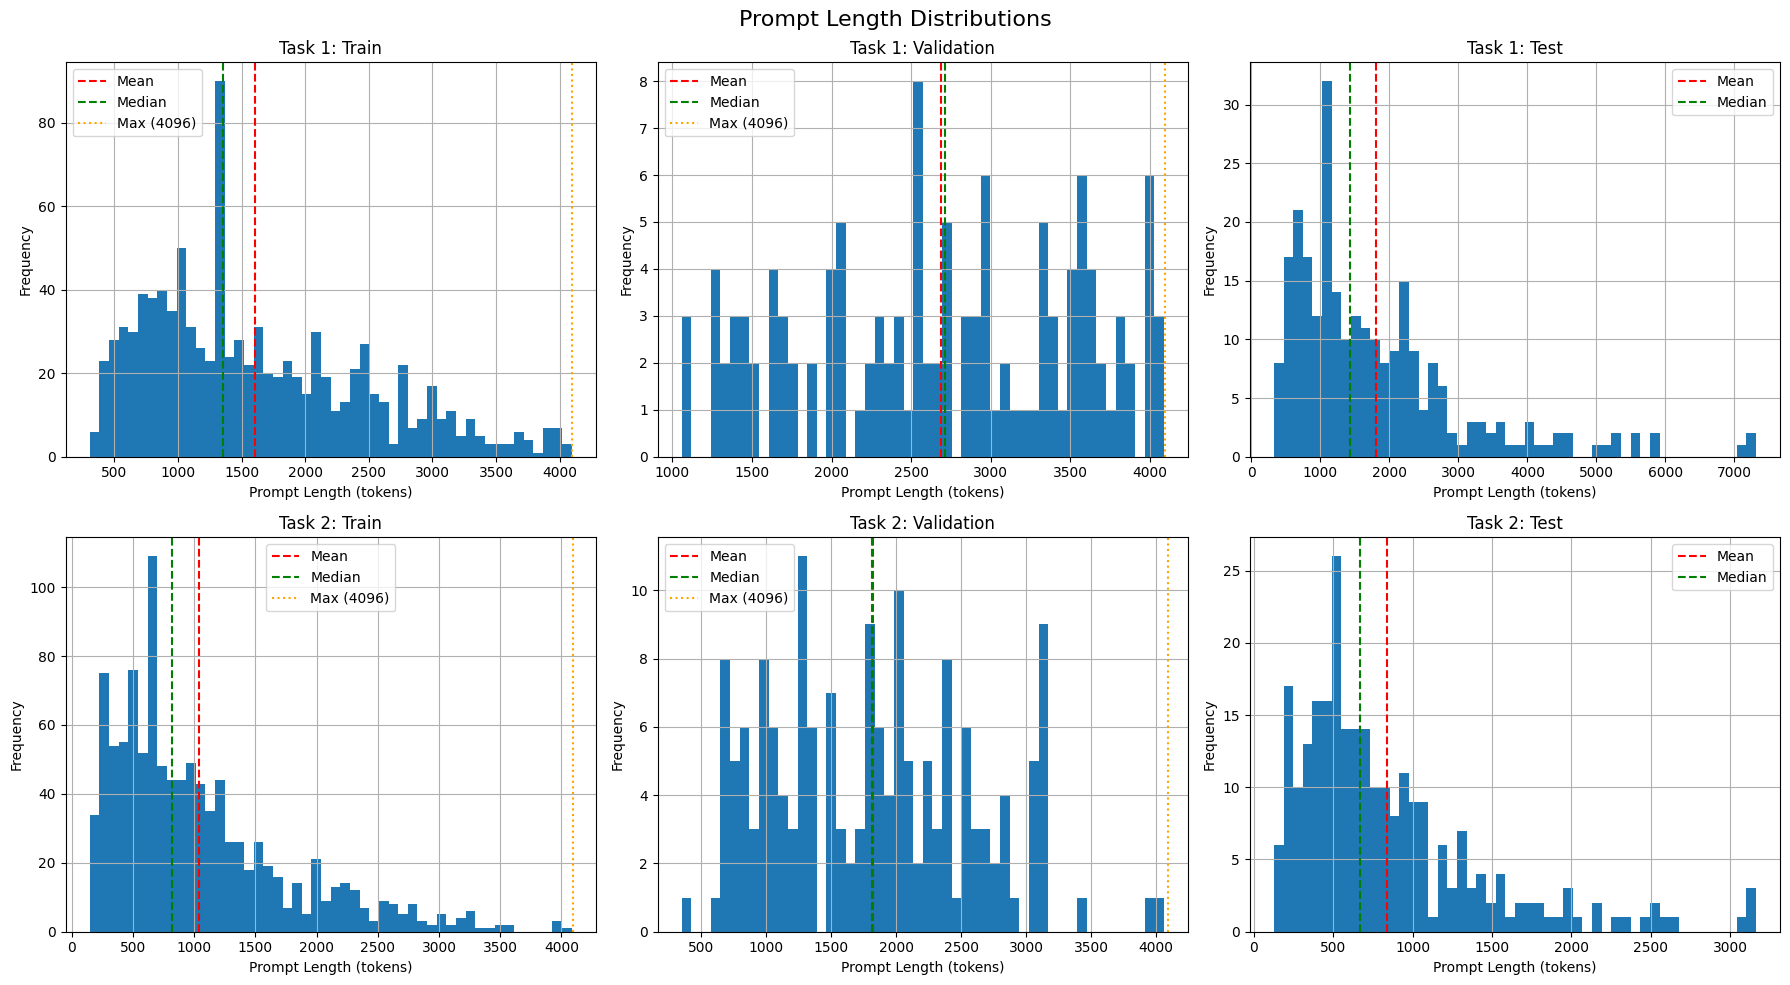

In [59]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Prompt Length Distributions', fontsize=16)

for idx, (name, df) in enumerate(datasets):
    ax = axes[idx // 3, idx % 3]
    df['prompt_length'].hist(bins=50, ax=ax)
    ax.set_title(name)
    ax.set_xlabel('Prompt Length (tokens)')
    ax.set_ylabel('Frequency')
    ax.axvline(df['prompt_length'].mean(), color='r', linestyle='--', label='Mean')
    ax.axvline(df['prompt_length'].median(), color='g', linestyle='--', label='Median')
    
    # Show max_seq_len line for train/val
    if 'Train' in name or 'Validation' in name:
        ax.axvline(cfg.max_seq_len, color='orange', linestyle=':', label=f'Max ({cfg.max_seq_len})')
    
    ax.legend()

plt.tight_layout()
plt.savefig(f'{output_dir}/prompt_length_distributions.png', dpi=150)
plt.show()

In [60]:
# Compare Task 1 vs Task 2 prompt lengths
print("\n" + "="*60)
print("TASK COMPARISON")
print("="*60)

print(f"\nTask 1 ({TASK1_PROMPT}):")
print(f"  Train samples: {len(task1_train_df)}")
print(f"  Val samples: {len(task1_val_df)}")
print(f"  Test samples: {len(task1_test_df)}")
print(f"  Avg prompt length: {task1_train_df['prompt_length'].mean():.0f} tokens")

print(f"\nTask 2 ({TASK2_PROMPT}):")
print(f"  Train samples: {len(task2_train_df)}")
print(f"  Val samples: {len(task2_val_df)}")
print(f"  Test samples: {len(task2_test_df)}")
print(f"  Avg prompt length: {task2_train_df['prompt_length'].mean():.0f} tokens")


TASK COMPARISON

Task 1 (output-from-examples-v1):
  Train samples: 974
  Val samples: 124
  Test samples: 259
  Avg prompt length: 1609 tokens

Task 2 (input-from-inputs-v0):
  Train samples: 1060
  Val samples: 166
  Test samples: 259
  Avg prompt length: 1041 tokens


## Summary

Созданы 6 датасетов с использованием CFG конфигурации:

**Configuration:**
- Model: Qwen/Qwen2.5-0.5B-Instruct
- Grid Encoder: GridShapeEncoder(RowNumberEncoder(MinimalGridEncoder()))
- Max Sequence Length: 4096 tokens

**Task 1 (examples + input → output):**
- `task1_train.parquet` - Тренировочный датасет
- `task1_validation.parquet` - Валидационный датасет
- `task1_test.parquet` - Тестовый датасет

**Task 2 (inputs → input - генерация):**
- `task2_train.parquet` - Тренировочный датасет
- `task2_validation.parquet` - Валидационный датасет
- `task2_test.parquet` - Тестовый датасет

**Дополнительно:**
- `config.json` - Полная конфигурация CFG

### Метаданные в каждом датасете:
- `text` - сгенерированный промпт
- `task_id` - идентификатор задачи
- `test_sample_index` - индекс тестового примера
- `prompt_length` - длина промпта в токенах
- `num_train_samples` - количество тренировочных примеров в задаче
- `input_height`, `input_width` - размеры входной сетки
- `output_height`, `output_width` - размеры выходной сетки (только для train/val)

### Использование:
```python
import pandas as pd
import json

# Load configuration
with open('datasets_qwen25/config.json', 'r') as f:
    config = json.load(f)

# Load dataset
df = pd.read_parquet('datasets_qwen25/task1_train.parquet')

# Convert to HuggingFace Dataset
from datasets import Dataset
hf_dataset = Dataset.from_pandas(df)
```